In [2]:
import pandas as pd
import matplotlib.pyplot as plt

from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from statsmodels.tsa.ar_model import ar_select_order
from statsmodels.tsa.ar_model import AutoReg
from statsmodels.tsa.arima.model import ARIMA

# Set the figure size to (14,6)
plt.rcParams['figure.figsize'] = (14,6)

# Warmup

## 1) Load the Data

In [3]:
df = pd.read_csv('arma_process.csv')
df.head()

,remainder
0,1.668068
1,3.594771
2,4.674503
3,3.665661
4,3.496006


## 2) Plot the Data

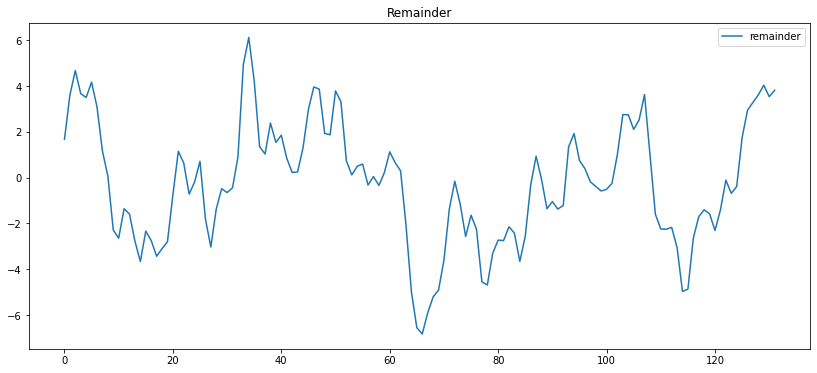

In [4]:
df.plot()
plt.title('Remainder')
plt.show()

In [48]:
df.mean()

remainder   -0.245466
dtype: float64

## 3) Inspect the Partial Autocorrelation and use ar_select_order

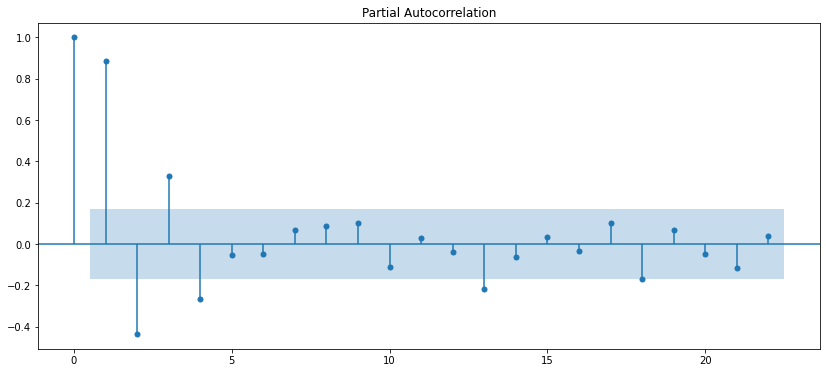

In [5]:
# Plot the partial autocorrelation function
plot_pacf(df);

Inspecting the pacf plot we choose to include 4 lags into our model following the Box-Jenkins-Methodology

In [6]:
# Use ar_select_order
order = ar_select_order(df, maxlag=10, old_names=False)

In [7]:
# How many lags does ar_select_order suggest?
order.ar_lags

array([1, 2, 3, 4])

## 4) Choose number of lags

Everything points us towards using 4 lags for our model

In [9]:
# Fit a statsmodels AutoReg model
ar_model = AutoReg(df, lags=4, old_names=False).fit()

In [10]:
# Look at the summary
ar_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                            AutoReg Model Results                             
==============================================================================
Dep. Variable:              remainder   No. Observations:                  132
Model:                     AutoReg(4)   Log Likelihood                -178.289
Method:               Conditional MLE   S.D. of innovations              0.974
Date:                Thu, 29 Apr 2021   AIC                              0.042
Time:                        10:27:37   BIC                              0.175
Sample:                             4   HQIC                             0.096
                                  132                                         
================================================================================
                   coef    std err          z      P>|z|      [0.025      0.975]
--------------------------------------------------------------------------------
const           -0.0448      0.087     -0.513      0.608      -0.216       0.126
remainder.L1     1.5259      0.084     18.093      0.000       1.361       1.691
remainder.L2    -1.1513      0.142     -8.087      0.000      -1.430      -0.872
remainder.L3     0.8005      0.142      5.637      0.000       0.522       1.079
remainder.L4    -0.3105      0.084     -3.704      0.000      -0.475      -0.146
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            0.0220           -1.3818j            1.3820           -0.2475
AR.2            0.0220           +1.3818j            1.3820            0.2475
AR.3            1.2671           -0.2841j            1.2986           -0.0351
AR.4            1.2671           +0.2841j            1.2986            0.0351
-----------------------------------------------------------------------------
"""

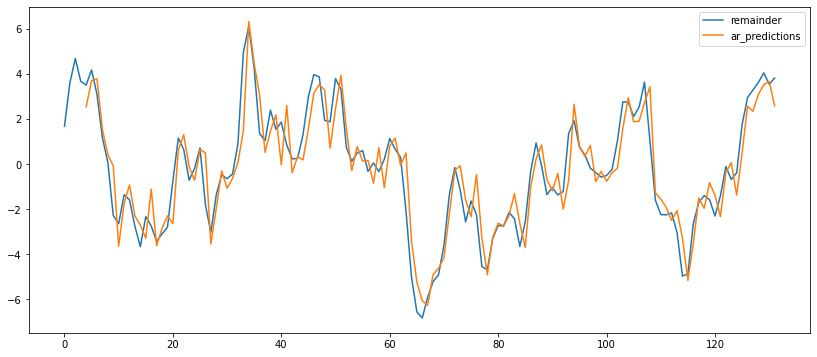

In [13]:
# Plot the prediction
df.plot()
plt.plot(ar_model.predict(), label='ar_predictions')
plt.legend()
plt.show()

# Looks good! Can we do better?

## ARIMA - Autoregressive Integrated Moving Average

With the AR model we found a quite decent model for our data. The question is, can we do even better? One way we might be able to improve our model is by including a Moving Average part (MA) into the model. Simply speaking the MA part is just a different way of modeling time dependence (modelling the remainder). Instead of using past values of the variable itself we will use past prediction errors to predict the future. Mathematically this looks like:

### L5.1) AR(p)

The $AR(p)$ part is just an autoregressive part of the model where *p* denotes the number of lags to include.

### L5.2) I(d)

The $I(d)$ part is just the part where the model is detrended. *d* determines which order of differencing should be applied to the original time series data before modelling the AR and MA parts. My suggestion is to ignore that part and tell students that modelling the trend took care of this.

### L5.3) MA(q)

This is the new part that we have not seen before. MA stands for Moving Average. Simply speaking it is just another way of modelling time dependence. Instead of regressing on past lags, the Moving Average approach regresses on past errors:

**MA(1):** $\hat{y_{t+1}} = b + \phi*\epsilon_{t}$

or adding more features (lags):

**MA(2):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + \phi_2*\epsilon_{t-1}$

or adding more features (lags):

**MA(q):** $\hat{y_{t+1}} = b + \phi_1*\epsilon_{t} + ... + \phi_q*\epsilon_{t-q-1}$


### How do we determine the order of the MA term q?

Instead of looking at the partial autocorrelation as was the case for the AR model we can look at the autocorrelation between observations $y_t$ and $y_{t-h}$.

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

What does the Box-Jenkins method say here:

#### "Value of q
The value of q is found from the autocorrelations [...]. If the autocorrelations
cut off after a few lags, the last lag with a large value would be the estimated value of q. If the autocorrelations do not cut off, you either have an autoregressive model (q=0) or an ARIMA model with a positive p and q."

https://www.ncss.com/wp-content/themes/ncss/pdf/Procedures/NCSS/The_Box-Jenkins_Method.pdf

# I in fact know that we are dealing with an ARIMA(1,0,1) process.

In [19]:
# Fit an ARIMA model
arima_model = ARIMA(df, order=(1,0,1)).fit()

# order defines (#of AR lags, I, #of MA lags); (p,d,q)
# (1,0,1) - means that we have 1 AR lag and 1 MA lag

$$
\hat{y_{t+1}} = b + w_1 * y_t + \phi_1 * \epsilon_t
$$

In [15]:
# Look at the summary
arima_model.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                               SARIMAX Results                                
==============================================================================
Dep. Variable:              remainder   No. Observations:                  132
Model:                 ARIMA(1, 0, 1)   Log Likelihood                -185.417
Date:                Thu, 29 Apr 2021   AIC                            378.834
Time:                        10:45:09   BIC                            390.365
Sample:                             0   HQIC                           383.520
                                - 132                                         
Covariance Type:                  opg                                         
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.0712      0.697     -0.102      0.919      -1.436       1.294
ar.L1          0.7772      0.063     12.281      0.000       0.653       0.901
ma.L1          0.8252      0.058     14.118      0.000       0.711       0.940
sigma2         0.9496      0.104      9.134      0.000       0.746       1.153
===================================================================================
Ljung-Box (L1) (Q):                   0.01   Jarque-Bera (JB):                 1.69
Prob(Q):                              0.94   Prob(JB):                         0.43
Heteroskedasticity (H):               0.61   Skew:                            -0.04
Prob(H) (two-sided):                  0.10   Kurtosis:                         3.55
===================================================================================

Warnings:
[1] Covariance matrix calculated using the outer product of gradients (complex-step).
"""

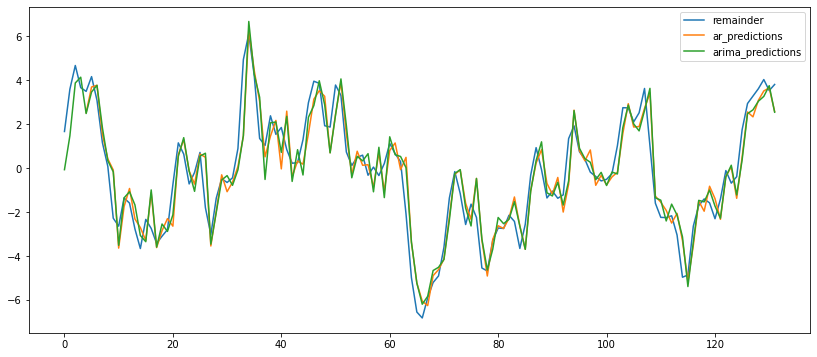

In [20]:
# Plot all time series
df.plot()
plt.plot(ar_model.predict(), label='ar_predictions')
plt.plot(arima_model.predict(), label='arima_predictions')
plt.legend()
plt.show()

## How do I determine which model to choose?

Analogous to the PACF_plot for the AR term, we can use the ACF_plot for the MA term. ACF stands for Autocorrelation function. Autocorrelation is defined as the correlation between lags.

$$
Corr(y_t, y_{t-h}) = \frac{Cov(y_t, y_{t-h})}{\sqrt{V(y_t)*V(y_{t-h})}}
$$

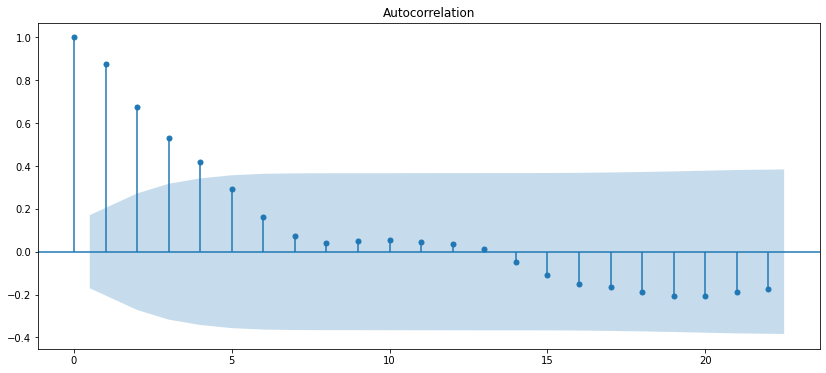

In [21]:
# Plot the autocorrelation between lags
plot_acf(df);

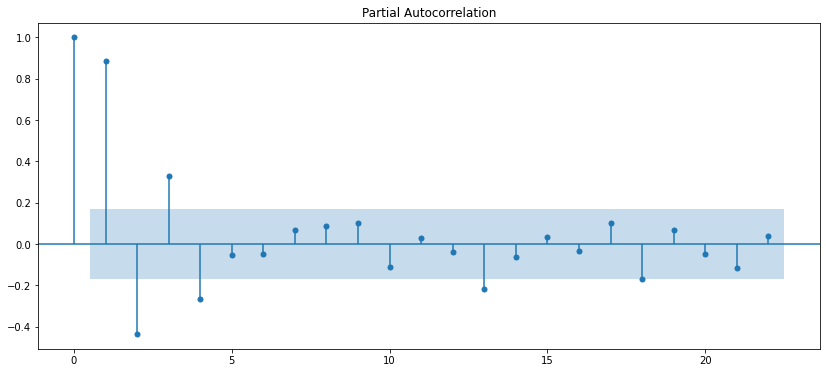

In [22]:
# Plot the partial autocorrelation between lags
plot_pacf(df);

Analogous to the plot of the partial autocorrelation for the AR part of the model, the plot of the autocorrelation function gives us an idea which lag to chose for the MA. If there is no clear cutoff this could mean

- That the time series is better modelled by a pure AR model
- That the time series is best modelled by a model including AR and MA terms (ARIMA)

### How to read the ACF-plot and the PACF-plot

Interpretation:

- If the ACF-Plot is showing an exponential and slow decay, and the PACF-Plot shows a drop after a certain lag, we conclude that the data is best modelled by an AR(p) process. p is given by the last meaningful lag in the PACF-Plot.

#### AR process

ACF-Plot AR(1)             |  PACF-Plot AR(1)
:-------------------------:|:-------------------------:
![](./images/acf_ar.png)   |  ![](./images/pacf_ar.png)

- If the ACF-Plot is showing a drop after a certain lag, and the PACF-Plot shows an exponential and slow decay, we conclude that the data is best modelled by an MA(q) process. q is given by the last meaningful lag in the ACF-Plot.

#### MA process

ACF-Plot MA(1)             |  PACF-Plot MA(1)
:-------------------------:|:-------------------------:
![](./images/acf_ma.png)   |  ![](./images/pacf_ma.png)

- If both the ACF-Plot and the PACF-Plot are showing an exponential and slow decay, we conclude that the data is best modelled by an ARIMA(p,d,q) process. p and q cannot be inferred from the plots. Usually you would use an iterrative approach and try different combinations to find the best model. (eg. https://alkaline-ml.com/pmdarima/modules/generated/pmdarima.arima.auto_arima.html)

#### ARIMA process

ACF-Plot ARIMA(1,0,1)      |  PACF-Plot ARIMA(1,0,1)
:-------------------------:|:-------------------------:
![](./images/acf_arima.png)|  ![](./images/pacf_arima.png)

# Let's look at the flights remainder

In [23]:
remainder = pd.read_csv('flights_remainder.csv', index_col=0, parse_dates=True)
remainder.head()

,remainder
date,
1949-01-01,4.405303
1949-02-01,17.496212
1949-03-01,7.496212
1949-04-01,9.587121
1949-05-01,-5.231061


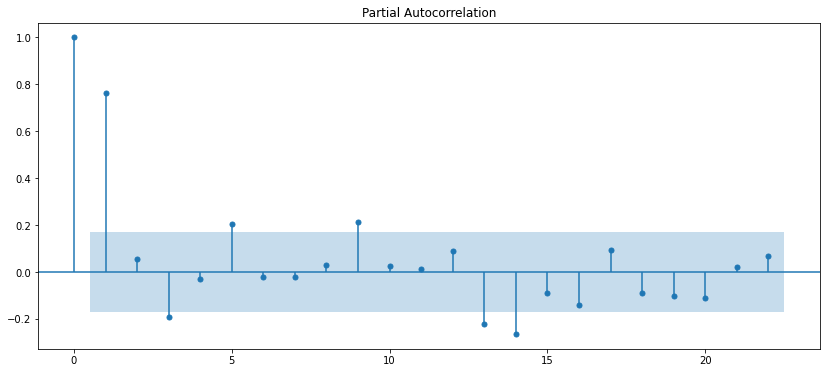

In [24]:
# Plot the partial autocorrelation
plot_pacf(remainder);

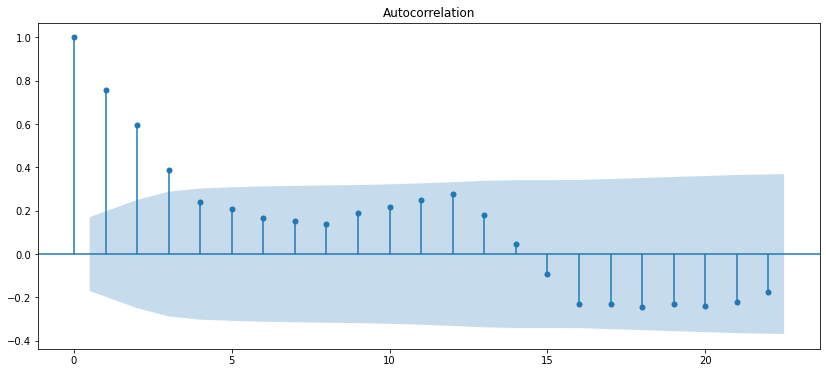

In [25]:
# Plot the autocorrelation
plot_acf(remainder);

# Integrated(I)

Integrating a time series is an alternative way to model a trend of the time series.

if $y_t$ is our time series, then $y_t - y_{t-1}$ would be the time series integrated by order 1: I(1)

In [26]:
x = list(range(100))

In [27]:
y = [value*2 for value in x]

In [29]:
linear = pd.DataFrame({'x': x, 'y': y})
linear.head()

,x,y
0,0,0
1,1,2
2,2,4
3,3,6
4,4,8


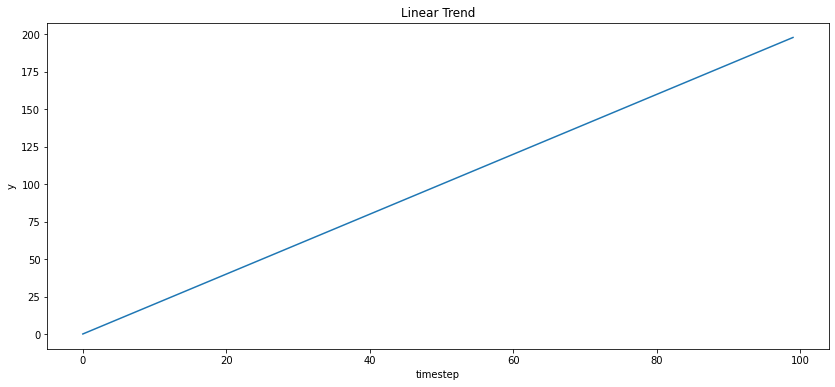

In [33]:
plt.plot(linear['x'], linear['y'])
plt.title('Linear Trend')
plt.xlabel('timestep')
plt.ylabel('y')
plt.show()

In [36]:
# Let's integrate the time series by order 1
# Integrating y will create a new time series, the difference of y between timesteps
# y_t - y_{t-1}
linear['y'] - linear['y'].shift(1)

0     NaN
1     2.0
2     2.0
3     2.0
4     2.0
     ... 
95    2.0
96    2.0
97    2.0
98    2.0
99    2.0
Name: y, Length: 100, dtype: float64

In [39]:
linear['integrated_y'] = linear['y'].diff()
linear.head()

,x,y,integrated_y
0,0,0,NaN
1,1,2,2.0
2,2,4,2.0
3,3,6,2.0
4,4,8,2.0


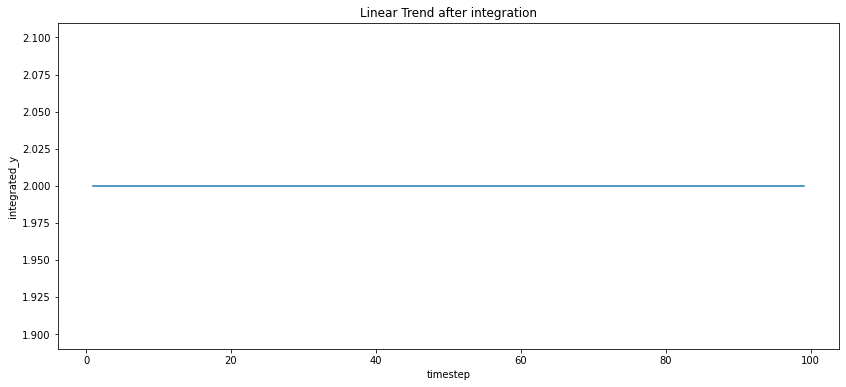

In [40]:
plt.plot(linear['x'], linear['integrated_y'])
plt.title('Linear Trend after integration')
plt.xlabel('timestep')
plt.ylabel('integrated_y')
plt.show()

In [42]:
# Let's look at an exponential trend
linear['y_sq'] = linear['x']**2
linear.head()

,x,y,integrated_y,y_sq
0,0,0,NaN,0
1,1,2,2.0,1
2,2,4,2.0,4
3,3,6,2.0,9
4,4,8,2.0,16


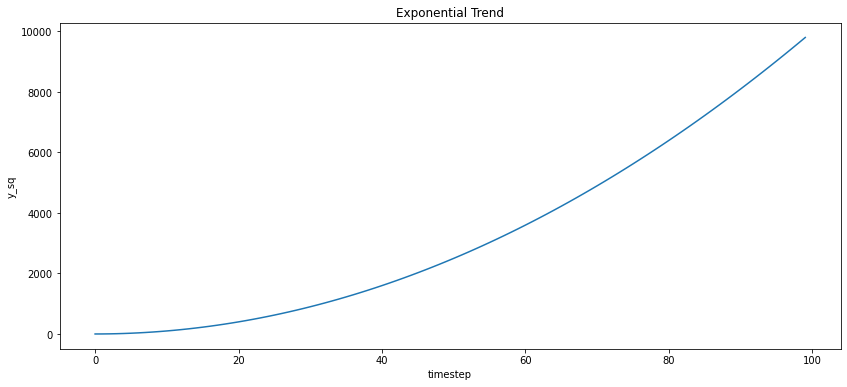

In [43]:
plt.plot(linear['x'], linear['y_sq'])
plt.title('Exponential Trend')
plt.xlabel('timestep')
plt.ylabel('y_sq')
plt.show()

In [44]:
# Detrend the time series with exponential trend by second order integration
# 1. order: y_t - y_{t-1}
# 2. order: (y_t - y_{t-1}) - (y_{t-1} - y_{t-2})
linear['y_sq_integrated'] = linear['y_sq'].diff().diff()
linear.head()

,x,y,integrated_y,y_sq,y_sq_integrated
0,0,0,NaN,0,NaN
1,1,2,2.0,1,NaN
2,2,4,2.0,4,2.0
3,3,6,2.0,9,2.0
4,4,8,2.0,16,2.0


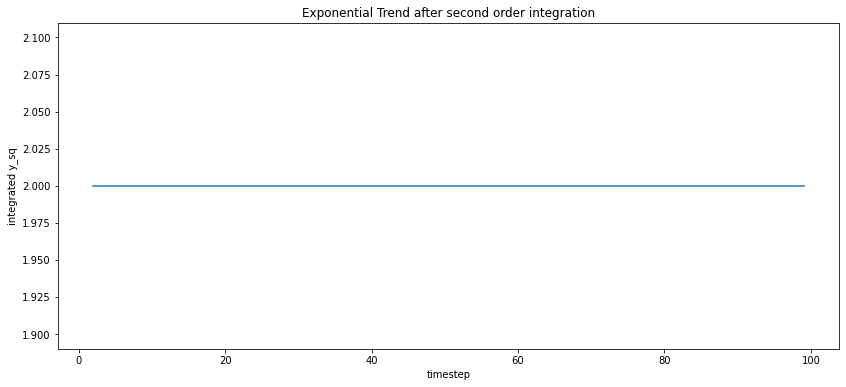

In [46]:
plt.plot(linear['x'], linear['y_sq_integrated'])
plt.title('Exponential Trend after second order integration')
plt.xlabel('timestep')
plt.ylabel('integrated y_sq')
plt.show()